In [ ]:
!pip install yfinance mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install mplfinance==0.12.9b7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: mplfinance
    Found existing installation: mplfinance 0.12.10b0
    Uninstalling mplfinance-0.12.10b0:
      Successfully uninstalled mplfinance-0.12.10b0


In [ ]:
pip install yfinance pandas numpy mplfinance matplotlib

In [ ]:
pip install --upgrade yfinance

In [ ]:
pip install yfinance pandas numpy mplfinance matplotlib

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import math

# === 2. 辅助函数 (简化) ===
def calculate_ema(series, period):
    """计算EMA (Exponential Moving Average)"""
    return series.ewm(span=period, adjust=False).mean()

def cross(series1, series2):
    """判断金叉/死叉"""
    return (series1.shift(1) <= series2.shift(1)) & (series1 > series2)

def backset(condition, bars):
    """模拟麦语言BACKSET函数"""
    result = pd.Series(np.zeros(len(condition)), index=condition.index)
    for i in range(len(condition)):
        if condition[i]:
            result[i-bars:i+1] = 1
    return result

def calculate_hhvbars(series, period):
    """计算最高价 Highest High Value 的周期"""
    return series.rolling(window=period).apply(lambda x: x.argmax(), raw=True)

def calculate_llvbars(series, period):
    """计算最低价 Lowest Low Value 的周期"""
    return series.rolling(window=period).apply(lambda x: x.argmin(), raw=True)


def analyze_data(df, initial_capital=10000, leverage=2, time_stop=30, stop_loss=0.05, stop_profit=0.2):
    """
    分析 DataFrame，同时进行做多和镜像做空策略，返回交易信号和净值曲线。
    :param df: 包含股票数据的 DataFrame。
    :param initial_capital: 初始资金。
    :param leverage: 杠杆倍数。
    :param time_stop:  如果持有超过 N 个周期，强制平仓
    :param stop_loss: 止损比例
    :param stop_profit: 止盈比例
    :return: df : the dateFram include data
             all_positions: 所有仓位信息
             sharpe_ratio: sharpe
             drawdown: maxDrawdown
             initial_capital: initial
             Final_Capital: final
    """

    # === 3. 核心指标计算 (改进顶底识别) ===
    SHORTP = 5
    LONGP = 34
    M = 5

    df['jjj'] = ((df['High'] + df['Low']) / 2 + df['Close']) / 2  # jjj
    df['DIFF'] = calculate_ema(df['jjj'], SHORTP) - calculate_ema(df['jjj'], LONGP)
    df['DEA'] = calculate_ema(df['DIFF'], M)
    df['MACD'] = 2 * (df['DIFF'] - df['DEA'])

    # === start: 3周期金叉死叉有效 ===
    df['金叉'] = cross(df['DIFF'], df['DEA'])
    df['死叉'] = cross(df['DEA'], df['DIFF'])

    #ref(Cross(DEA,DIFF),3) and  ref(Cross(DEA,DIFF),1) and ref(Cross(DEA,DIFF),2);
    valid_cross_period = 3 # 金叉/死叉有效周期
    df['死叉1'] = (df['死叉'].shift(valid_cross_period) & (df['DEA'] > df['DIFF']) & (df['DEA'].shift(1) > df['DIFF'].shift(1)) & (df['DEA'].shift(2) > df['DIFF'].shift(2)))
    df['金叉1'] = (df['金叉'].shift(valid_cross_period) & (df['DEA'] < df['DIFF']) & (df['DEA'].shift(1) < df['DIFF'].shift(1)) & (df['DEA'].shift(2) < df['DIFF'].shift(2)))
    df['死叉'] = df['死叉1'].astype(int)
    df['金叉'] = df['金叉1'].astype(int)
    # === end: 3周期金叉死叉有效 ===

    # === start: 标记顶底 开始 ===
    high_point_period = 5 # 高点周期
    low_point_period = 5 # 低点周期
    df['高点周期'] = np.where(df['死叉'] == 1,  calculate_llvbars(df['金叉'], high_point_period),
                           calculate_llvbars(df['死叉'], high_point_period))

    df['低点周期'] =  np.where(df['金叉'] == 1, calculate_hhvbars(df['死叉'], low_point_period),
                           calculate_hhvbars(df['金叉'], low_point_period))

    #顶:=BACKSET(死叉=1,HHVBARS(H,高点周期+3)+1); #顶
    top_backset_period = 5 # HHVBARS(H,高点周期+3)+1
    df['顶1'] = backset(df['死叉'] == 1, top_backset_period)
    df['底1'] = backset(df['金叉'] == 1, top_backset_period)

    # 顶底十字线
    #df['顶a'] = cross(df['顶1'].astype(float), 0.5).astype(int)  #
    #df['底a'] = cross(df['底1'].astype(float), 0.5).astype(int)

    df['顶a'] = (df['顶1'].shift(1) < 0.5) & (df['顶1'] > 0.5) #顶1类型转换
    df['底a'] = (df['底1'].shift(1) < 0.5) & (df['底1'] > 0.5)  #底1类型转换

    df['顶a'] =df['顶a'].astype(int) # 再次转回INT
    df['底a'] =df['底a'].astype(int) # 再次转回INT
    # === end: 标记顶底 结束 ===

    # === start: 找到顶底的索引和价格 ===
    top_indices = df[df['顶a'] == 1].index
    bottom_indices = df[df['底a'] == 1].index

    top_prices = df.loc[top_indices]['High']
    bottom_prices = df.loc[bottom_indices]['Low']
    # === end: 找到顶底的索引和价格 ===

    # 初始化交易状态
    long_positions = []  # 存储做多交易信号
    short_positions = []  # 存储做空交易信号
    all_positions = [] # 存储所有交易信息

    long_capital = initial_capital / 2 #做多本金
    short_capital = initial_capital / 2 #做空本金
    capital = initial_capital

    long_position = 0  # 0: no position, 1: long position
    short_position = 0  # 0: no position, -1: short position

    long_entry_index = None # 记录做多开仓index
    short_entry_index = None # 记录做空开仓index
    long_entry_price = None # 记录做多开仓价格
    short_entry_price = None # 记录做空开仓价格


    # 加入到信号之后才开始总资产变动
    total_equity = [initial_capital] # 总资金曲线
    equity = initial_capital
    long_units = 0
    short_units = 0

    # 循环遍历每一天的数据

    for i, row in df.iterrows():
        #######################做多
        #判断做多
        #入场：价格创新低，MACD没有创新低 (底背离)，且当前没有持仓
        if  long_position == 0 and row['底a'] == 1:
            #获取符合底背离标准的数据
            current_bottom_indices=df[df['底a'] == 1].index
            if len(current_bottom_indices)>1 :
                current_bottom_index=current_bottom_indices[-1]
                previous_bottom_index=current_bottom_indices[-2]
                current_bottom_price=df.loc[current_bottom_index]['Low']
                previous_bottom_price=df.loc[previous_bottom_index]['Low']
                current_macd_peak=df.loc[current_bottom_index]['MACD']
                previous_macd_peak=df.loc[previous_bottom_index]['MACD']
                if current_bottom_price < previous_bottom_price and current_macd_peak > previous_macd_peak:
                    #获取当前价格
                    entry_price=row['Close']
                    long_units= (long_capital * leverage) / entry_price
                    #设置做多状态
                    long_position=1
                    long_entry_index=i
                    long_entry_price = entry_price
                    all_positions.append([i,1,entry_price])

        #平仓：出现顶背离，或者达到时间止损或者止盈止损
        elif  long_position == 1 :
            holding_period = (i - long_entry_index).days  # 已经持仓的时间
            #平仓：出现顶背离
            current_top_indices=df[df['顶a'] == 1].index
            if len(current_top_indices)>1 :
                current_top_index=current_top_indices[-1]
                previous_top_index=current_top_indices[-2]
                current_top_price=df.loc[current_top_index]['High']
                previous_top_price=df.loc[previous_top_index]['High']
                current_macd_top=df.loc[current_top_index]['MACD']
                previous_macd_top=df.loc[previous_top_index]['MACD']
                if current_top_price>previous_top_price and current_macd_top<previous_macd_top:
                    #计算盈亏
                    #进行平仓
                    exit_price=row['Close']
                    profit= (exit_price - long_entry_price) * long_units
                    long_capital=long_capital + profit
                    equity=short_capital+long_capital
                    #改变状态
                    all_positions.append([i,0,exit_price])
                    long_position=0
                    long_entry_index=None
                    long_entry_price=None
                    long_units=0 #清空股票数量
                    #total_equity.append(equity)

            #或者达到时间止损
            elif holding_period>time_stop:
                # 时间到，强制平仓
                exit_price=row['Close']
                profit= (exit_price - long_entry_price) * long_units
                long_capital=long_capital + profit
                equity = short_capital + long_capital
                # 改变状态
                all_positions.append([i, 0, exit_price])
                long_position = 0
                long_entry_index = None
                long_entry_price = None
                long_units=0

            #止损和止盈
            elif row['Close'] <= long_entry_price * (1 - stop_loss) or row['Close'] >= long_entry_price * (1+stop_profit):
                # 止损/止盈
                exit_price = row['Close']
                profit = (exit_price - long_entry_price) * long_units
                long_capital = long_capital + profit
                equity = short_capital + long_capital
                all_positions.append([i, 0, exit_price])
                long_position = 0
                long_entry_index = None
                long_entry_price = None
                long_units=0

        #######################做空
        # 判断做空
        # 入场：价格创新高，MACD没有创新高 (顶背离)，且当前没有持仓
        if  short_position == 0 and row['顶a'] == 1:
            #获取顶背离数据
            current_top_indices=df[df['顶a'] == 1].index
            if len(current_top_indices)>1:
                current_top_index=current_top_indices[-1]
                previous_top_index=current_top_indices[-2]
                current_top_price=df.loc[current_top_index]['High']
                previous_top_price=df.loc[previous_top_index]['High']
                current_macd_top=df.loc[current_top_index]['MACD']
                previous_macd_top=df.loc[previous_top_index]['MACD']

                # 价格创新高，MACD没有创新高 (顶背离)
                if current_top_price > previous_top_price and current_macd_top < previous_macd_top:
                    #获取当前价格
                    entry_price=row['Close']
                    short_units= (short_capital * leverage) / entry_price
                    #改变状态
                    short_position = -1
                    short_entry_index = i
                    short_entry_price = entry_price
                    all_positions.append([i, -1, entry_price])

        # 平仓条件：出现底背离 或者时间止损 或者止盈止损
        elif  short_position == -1:
            holding_period = (i - short_entry_index).days
            #获取底背离数据
            current_bottom_indices = df[df['底a'] == 1].index
            if len(current_bottom_indices)>1 :
                current_bottom_index = current_bottom_indices[-1]
                previous_bottom_index = current_bottom_indices[-2]
                current_bottom_price = df.loc[current_bottom_index]['Low']
                previous_bottom_price = df.loc[previous_bottom_index]['Low']
                current_macd_bottom = df.loc[current_bottom_index]['MACD']
                previous_macd_bottom = df.loc[previous_bottom_index]['MACD']
                if current_bottom_price < previous_bottom_price and current_macd_bottom > previous_macd_bottom:

                    #计算盈亏
                    exit_price=row['Close']
                    profit= (short_entry_price - exit_price) * short_units
                    short_capital=short_capital+profit
                    equity=short_capital+long_capital
                    #改变状态
                    all_positions.append([i, 0, exit_price])
                    short_position = 0
                    short_entry_index = None
                    short_entry_price = None
                    short_units=0
            #时间止损
            elif holding_period>time_stop:
                #结算
                exit_price = row['Close']
                profit = (short_entry_price - exit_price) * short_units
                short_capital = short_capital + profit
                equity = short_capital + long_capital
                #修改状态
                all_positions.append([i, 0, exit_price])
                short_position = 0
                short_entry_index = None
                short_entry_price = None
                short_units=0
            #价格波动止损
            elif row['Close'] >= short_entry_price * (1 + stop_loss) or row['Close'] <= short_entry_price * (1- stop_profit):
                # 止损/止盈
                exit_price = row['Close']
                profit = (short_entry_price - exit_price) * short_units
                short_capital = short_capital + profit
                equity = short_capital + long_capital
                all_positions.append([i, 0, exit_price])
                short_position = 0
                short_entry_index = None
                short_entry_price = None
                short_units=0

        # 确保equity在每次循环中更新
        equity = short_capital + long_capital
        # 记录当天的总资产
        total_equity.append(equity)
    df['total_equity'] = total_equity[0:len(df)]

    #计算夏普指数
    returns=pd.Series(total_equity).pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() if returns.std() else 0
    #最大回撤
    peak = max(total_equity)
    drawdown = (peak - total_equity[-1]) / peak if peak!=0 else 0
    #最终结果
    Final_Capital=total_equity[-1]

    return df, all_positions,sharpe_ratio,drawdown,initial_capital,Final_Capital

In [ ]:
def draw_trendlines(df, positions=None, sharpe_ratio=None, drawdown=None, initial_capital=None, final_capital=None):
    """
    根据给定的 DataFrame 绘制 K 线图和趋势线，并标记交易信号。
    """

    # === 3. 核心指标计算 (改进顶底识别) ===
    SHORTP = 5
    LONGP = 34
    M = 5

    df['jjj'] = ((df['High'] + df['Low']) / 2 + df['Close']) / 2  # jjj
    df['DIFF'] = calculate_ema(df['jjj'], SHORTP) - calculate_ema(df['jjj'], LONGP)
    df['DEA'] = calculate_ema(df['DIFF'], M)
    df['MACD'] = 2 * (df['DIFF'] - df['DEA'])

    # === start: 3周期金叉死叉有效 ===
    df['金叉'] = cross(df['DIFF'], df['DEA'])
    df['死叉'] = cross(df['DEA'], df['DIFF'])

    #ref(Cross(DEA,DIFF),3) and  ref(Cross(DEA,DIFF),1) and ref(Cross(DEA,DIFF),2);
    valid_cross_period = 3 # 金叉/死叉有效周期
    df['死叉1'] = (df['死叉'].shift(valid_cross_period) & (df['DEA'] > df['DIFF']) & (df['DEA'].shift(1) > df['DIFF'].shift(1)) & (df['DEA'].shift(2) > df['DIFF'].shift(2)))
    df['金叉1'] = (df['金叉'].shift(valid_cross_period) & (df['DEA'] < df['DIFF']) & (df['DEA'].shift(1) < df['DIFF'].shift(1)) & (df['DEA'].shift(2) < df['DIFF'].shift(2)))
    df['死叉'] = df['死叉1'].astype(int)
    df['金叉'] = df['金叉1'].astype(int)
    # === end: 3周期金叉死叉有效 ===

    # === start: 标记顶底 开始 ===
    high_point_period = 5 # 高点周期
    low_point_period = 5 # 低点周期
    df['高点周期'] = np.where(df['死叉'] == 1,  calculate_llvbars(df['金叉'], high_point_period),
                           calculate_llvbars(df['死叉'], high_point_period))

    df['低点周期'] =  np.where(df['金叉'] == 1, calculate_hhvbars(df['死叉'], low_point_period),
                           calculate_hhvbars(df['金叉'], low_point_period))

    #顶:=BACKSET(死叉=1,HHVBARS(H,高点周期+3)+1); #顶
    top_backset_period = 5 # HHVBARS(H,高点周期+3)+1
    df['顶1'] = backset(df['死叉'] == 1, top_backset_period)
    df['底1'] = backset(df['金叉'] == 1, top_backset_period)

    # 顶底十字线
    #df['顶a'] = cross(df['顶1'].astype(float), 0.5).astype(int)  #
    #df['底a'] = cross(df['底1'].astype(float), 0.5).astype(int)

    df['顶a'] = (df['顶1'].shift(1) < 0.5) & (df['顶1'] > 0.5) #顶1类型转换
    df['底a'] = (df['底1'].shift(1) < 0.5) & (df['底1'] > 0.5)  #底1类型转换

    df['顶a'] =df['顶a'].astype(int) # 再次转回INT
    df['底a'] =df['底a'].astype(int) # 再次转回INT
    # === end: 标记顶底 结束 ===

    # === start: 找到顶底的索引和价格 ===
    top_indices = df[df['顶a'] == 1].index
    bottom_indices = df[df['底a'] == 1].index

    top_prices = df.loc[top_indices]['High']
    bottom_prices = df.loc[bottom_indices]['Low']
    # === end: 找到顶底的索引和价格 ===

    # === start: 准备画线数据 (改进画线逻辑) ===
    # 构建alines (连接所有相邻的顶底)
    alines = []
    points = [] #  存储顶和底的(时间, 价格)
    for top_index in top_indices:
        points.append((top_index, df.loc[top_index]['High']))
    for bottom_index in bottom_indices:
        points.append((bottom_index, df.loc[bottom_index]['Low']))

    # 按照时间排序
    points.sort(key=lambda x: x[0])

    #  连接相邻点
    # 构建 alines (尽可能合并同方向和“平台整理”的线段)
    merged_alines = []
    if len(points) >= 2:
        start_point = points[0]
        for i in range(1, len(points)):
            end_point = points[i]
            # 判断线段方向 (上涨或下降)
            if end_point[1] > start_point[1]:
                direction = 'up'  # 上涨
            else:
                direction = 'down'  # 下降
            #如果前一个段是空， 直接添加
            if  len(merged_alines) == 0:
                 merged_alines.append((start_point, end_point, direction)) # 添加新线段
            else:
                last_start, last_end, last_direction = merged_alines[-1]
                if direction == last_direction: # 如果方向相等， 就合并
                    merged_alines[-1] = (last_start, end_point, direction)
                else:  # 方向不相等， 结束上一个，开始新的
                    merged_alines.append((start_point, end_point, direction)) # 添加新线段
            start_point = end_point # 重置起始点

    # 转换回 alines
    alines = [(item[0], item[1]) for item in merged_alines]
    # === end: 准备画线数据 (改进画线逻辑) ===

    # === 6.  使用 mplfinance 绘制K线图，并添加标记和线 ===
    apds = [] #  添加技术指标线，例如EMA
    apds.append(mpf.make_addplot(df['DIFF'], panel=1, color='blue'))
    apds.append(mpf.make_addplot(df['DEA'], panel=1, color='orange'))
    apds.append(mpf.make_addplot(df['total_equity'], panel=2, color='green', ylabel='Equity')) #净值曲线

    # 构建标记
    amarkers = []
    amarkers += [
        (top_index, df.loc[top_index]['High'], '^', 'red') for top_index in top_indices
    ]
    amarkers += [
        (bottom_index, df.loc[bottom_index]['Low'], 'v', 'green') for bottom_index in bottom_indices
    ]

    # 添加交易信号标记
    if positions:
        for trade in positions:
            index, action, price = trade
            if action == 1:  # 做多信号
                amarkers.append((index, df.loc[index]['Low'], 'd', 'blue'))  # 'd' 表示菱形
            elif action == -1:  # 做空信号
                amarkers.append((index, df.loc[index]['High'], 'd', 'purple'))  # 'd' 表示菱形
            elif action == 0:  # 平仓信号
                 if index in top_indices: # 顶部的平仓
                     amarkers.append((index, df.loc[index]['Low'], 'o', 'black'))  # 'o' 表示圆圈
                 elif index in bottom_indices:#底部的平仓
                     amarkers.append((index, df.loc[index]['High'], 'o', 'black'))  # 'o' 表示圆圈


    fig, axes = mpf.plot(df,
                    type='candle',
                    # title=f'{ticker} - 最近一年日线',  移除中文标题
                    volume=False,
                    show_nontrading=False,
                    addplot=apds,
                    panel_ratios=(2,1,1), # K线图、指标图的比例
                    alines=alines, # 添加趋势线
                    style='yahoo', # 样式
                    figsize=(12, 8), # 图表大小
                    returnfig=True, # 返回 Figure 对象
                    )
    ax = axes[0] # 第一个axes是K线图

    # 添加注释

    ax.annotate(f"Initial Capital: {initial_capital:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')
    ax.annotate(f"Final Capital: {final_capital:.2f}", xy=(0.05, 0.90), xycoords='axes fraction')
    ax.annotate(f"Total P/L: {final_capital - initial_capital:.2f}", xy=(0.05, 0.85), xycoords='axes fraction')
    ax.annotate(f"Max Drawdown: {drawdown:.2f}", xy=(0.05, 0.80), xycoords='axes fraction')
    ax.annotate(f"Sharpe Ratio: {sharpe_ratio:.2f}", xy=(0.05, 0.75), xycoords='axes fraction')

    if len(amarkers) > 0 :
        for mark in amarkers:
            ax.annotate(mark[2], (mark[0], mark[1]), xytext=(mark[0], mark[1] * 1.02),
                        arrowprops=dict(arrowstyle='-|>', color=mark[3])) # 文本和箭头


    fig.show() # 或者使用 mpf.show()  显示图表

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c0e532d4c198>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[i]:
<ipython-input-6-c0e532d4c198>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[i]:


Initial Capital: 10000
Final Capital: 29303.72331083608
Total P/L: 19303.72331083608
Max Drawdown: 0.024084540404051287
Sharpe Ratio: 0.07798943489256613


<ipython-input-6-c0e532d4c198>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[i]:
/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


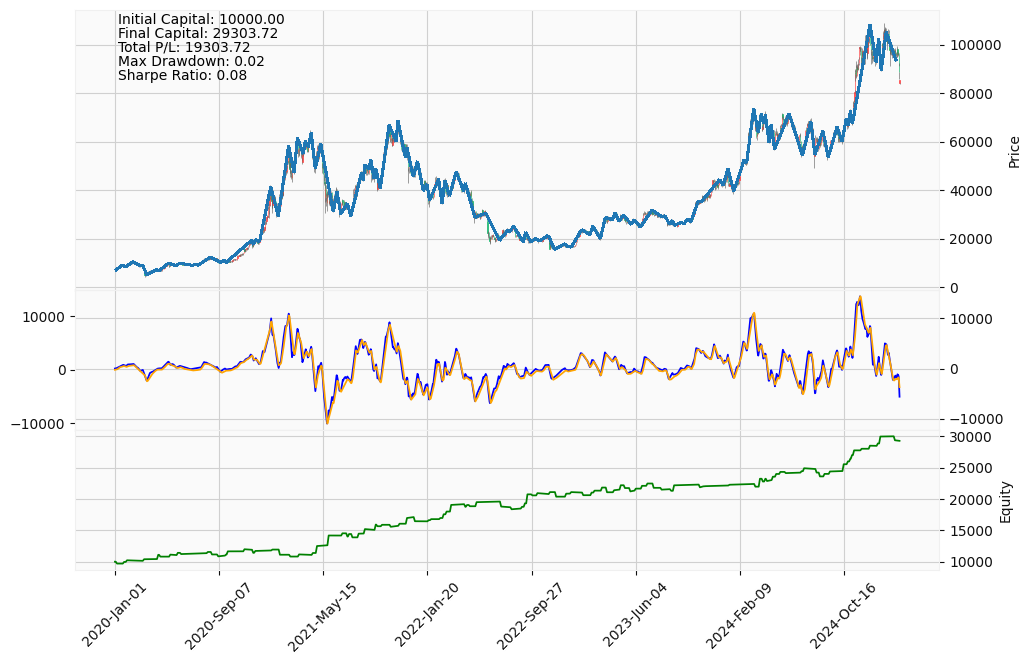

In [ ]:
if __name__ == '__main__':
    # 1. 下载 Apple (AAPL) 近一年的日线数据
    ticker = "BTC-USD"  # 使用比特币
    start_date = pd.Timestamp('2020-01-01') # 指定2020年开始
    end_date = pd.Timestamp.today()
    initial_capital = 10000 #初始资金
    leverage = 2 # 2倍杠杆
    time_stop = 30 # 时间止损
    stop_loss = 0.05 # 止损
    stop_profit=0.2 # 止盈
    data = yf.download(ticker, start=start_date, end=end_date) # 使用end
    df = pd.DataFrame(data)

    # 检查下载的数据是否已经包含 'Adj Close'
    if 'Adj Close' in df.columns:
        df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] # mplfinance 需要这些列名
    else:
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume'] # 如果没有 'Adj Close', 就只设置 5 个列名

    df, all_positions,sharpe_ratio,drawdown,initial_capital,Final_Capital = analyze_data(df, initial_capital, leverage, time_stop,stop_loss,stop_profit)
    print(f"Initial Capital: {initial_capital}")
    print(f"Final Capital: {Final_Capital}")
    print(f"Total P/L: {Final_Capital - initial_capital}")
    print(f"Max Drawdown: {drawdown}")
    print(f"Sharpe Ratio: {sharpe_ratio}")
    draw_trendlines(df, all_positions,sharpe_ratio,drawdown,initial_capital,Final_Capital)